In [2]:
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import torch
import torch.nn as nn
#from sklearn.metrics.pairwise import cosine_similarity

from utils2 import sigmoid, get_batches, compute_pca, get_dict

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/sazimov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
# Download sentence tokenizer
nltk.data.path.append('.')

# Load, tokenize and process the data
import re
with open('./data/shakespeare.txt') as f:
    data = f.read()
data = re.sub(r'[,.!?;-]', '',data)
data = nltk.word_tokenize(data)
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']
print("Number of tokens:", len(data),'\n', data[:10])

# Compute the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ", len(fdist))
print("Most frequent tokens: ", fdist.most_common(100))

# get_dict creates two dictionaries, converting words to indices and viceversa.
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

raw_data = data
vocab = set(raw_data)


Number of tokens: 51566 
 ['o', 'for', 'a', 'muse', 'of', 'fire', 'that', 'would', 'ascend', 'the']
Size of vocabulary:  2357
Most frequent tokens:  [('the', 352), ('and', 311), ('of', 253), ('to', 229), ('in', 196), ('my', 174), ('that', 161), ('i', 149), ('with', 122), ('for', 106), ('a', 105), ('thy', 89), ('his', 88), ('but', 87), ('thou', 86), ('your', 84), ('you', 83), ('is', 78), ('love', 76), ('as', 73), ('this', 71), ('all', 69), ('not', 69), ('so', 68), ('when', 62), ('thee', 61), ('me', 58), ('be', 58), ('which', 57), ('it', 57), ('from', 52), ('by', 50), ('shall', 48), ('on', 43), ('or', 43), ('we', 42), ('are', 42), ('then', 41), ('time', 41), ('their', 39), ('doth', 39), ('do', 39), ('our', 38), ('self', 38), ('have', 36), ('king', 35), ('no', 35), ('mine', 33), ('more', 32), ('at', 31), ('can', 31), ('france', 31), ('make', 29), ('him', 29), ('one', 29), ('hath', 28), ('like', 27), ('how', 27), ('will', 27), ('o', 26), ('should', 26), ('they', 26), ('what', 26), ('beauty

In [29]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

CONTEXT_SIZE = 2
EMDEDDING_DIM = 100

vocab_size = len(vocab)

word_to_ix = {word:ix for ix, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}

data = []
for i in range(2, len(raw_data) - 2):
    context = [raw_data[i - 2], raw_data[i - 1],
               raw_data[i + 1], raw_data[i + 2]]
    target = raw_data[i]
    data.append((context, target))


class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()

        #out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()
        
        #out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim = -1)
        
    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)


In [5]:
model = CBOW(vocab_size, EMDEDDING_DIM)
loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [30]:

data_size = 50000
epochs = 100

#TRAINING
for epoch in range(1, epochs+1):
    print(f"EPOCH {epoch}")
    ind = 0
    total_loss = 0
    for context, target in data[:data_size]:
        ind += 1
        if ind % 10000 == 0:
            print(ind)
            
        context_vector = make_context_vector(context, word_to_ix)  
        log_probs = model(context_vector)
        total_loss += loss_function(log_probs, torch.tensor([word_to_ix[target]]))

    #optimize at the end of each epoch
    optimizer.zero_grad()
    print("total_loss.backward()")
    total_loss.backward()
    print("optimizer.step()")
    optimizer.step()
    print(f"total loss {total_loss.tolist()}")
    print(f"avg loss {total_loss.tolist()/data_size}")
    
    count = 0
    for context, y in data[:data_size]:
        context_vector = make_context_vector(context, word_to_ix)
        a = model(context_vector)
        yhat = ix_to_word[torch.argmax(a[0]).item()]
        if y == yhat:
            count += 1

    print(f"Accuracy: {count / data_size}\n")

EPOCH 1
10000
20000
30000
40000
50000
total_loss.backward()
optimizer.step()
total loss 110985.9921875
avg loss 2.21971984375
Accuracy: 0.51788

EPOCH 2
10000
20000
30000
40000
50000
total_loss.backward()
optimizer.step()
total loss 108867.7265625
avg loss 2.17735453125
Accuracy: 0.52738

EPOCH 3
10000
20000
30000
40000
50000
total_loss.backward()
optimizer.step()
total loss 106804.984375
avg loss 2.1360996875
Accuracy: 0.53532

EPOCH 4
10000
20000
30000
40000
50000
total_loss.backward()
optimizer.step()
total loss 104787.34375
avg loss 2.095746875
Accuracy: 0.54294

EPOCH 5
10000
20000
30000
40000
50000
total_loss.backward()
optimizer.step()
total loss 102780.3046875
avg loss 2.05560609375
Accuracy: 0.55

EPOCH 6
10000
20000
30000
40000
50000
total_loss.backward()
optimizer.step()
total loss 100846.953125
avg loss 2.0169390625
Accuracy: 0.55884

EPOCH 7
10000
20000
30000
40000
50000
total_loss.backward()
optimizer.step()
total loss 98920.7734375
avg loss 1.97841546875
Accuracy: 0.5672

In [31]:
PATH = './m'

In [32]:
torch.save(model.state_dict(), PATH)

In [ ]:
model.load_state_dict(torch.load(PATH))

In [54]:
data[40500:40550]

[(['moved', 'the', 'my', 'master'], 'king'),
 (['the', 'king', 'master', 'to'], 'my'),
 (['king', 'my', 'to', 'speak'], 'master'),
 (['my', 'master', 'speak', 'in'], 'to'),
 (['master', 'to', 'in', 'the'], 'speak'),
 (['to', 'speak', 'the', 'behalf'], 'in'),
 (['speak', 'in', 'behalf', 'of'], 'the'),
 (['in', 'the', 'of', 'my'], 'behalf'),
 (['the', 'behalf', 'my', 'daughter'], 'of'),
 (['behalf', 'of', 'daughter', 'which'], 'my'),
 (['of', 'my', 'which', 'in'], 'daughter'),
 (['my', 'daughter', 'in', 'the'], 'which'),
 (['daughter', 'which', 'the', 'minority'], 'in'),
 (['which', 'in', 'minority', 'of'], 'the'),
 (['in', 'the', 'of', 'them'], 'minority'),
 (['the', 'minority', 'them', 'both'], 'of'),
 (['minority', 'of', 'both', 'his'], 'them'),
 (['of', 'them', 'his', 'majesty'], 'both'),
 (['them', 'both', 'majesty', 'out'], 'his'),
 (['both', 'his', 'out', 'of'], 'majesty'),
 (['his', 'majesty', 'of', 'a'], 'out'),
 (['majesty', 'out', 'a', 'selfgracious'], 'of'),
 (['out', 'of', '

In [58]:
#TESTING
context = ['the', 'brightest', 'of', 'invention']
context_vector = make_context_vector(context, word_to_ix)
a = model(context_vector)

#Print result
print(f'Context: {context}\n')
print(f'Prediction: {ix_to_word[torch.argmax(a[0]).item()]}')


Context: ['the', 'brightest', 'of', 'invention']

Prediction: heaven


<a name='3'></a>
## Visualizing the word vectors

In this part you will visualize the word vectors trained using the function you just coded above. 

In [34]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','dog','wolf',
         'rich','happy','sad']

embs = model.linear2.weight.detach().numpy()
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each 

(10, 128) [2798, 4043, 3016, 3084, 5833, 1472, 5832, 4288, 2353, 4378]


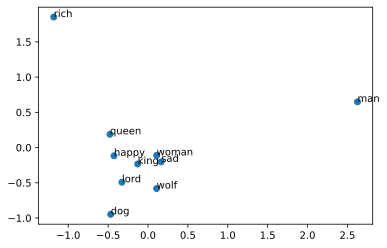

In [35]:
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

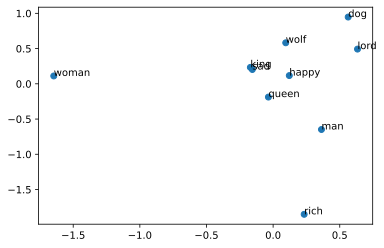

In [36]:
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()

In [37]:
def cosine_similarity(a, b):
    nominator = np.dot(a, b)
    
    a_norm = np.sqrt(np.sum(a**2))
    b_norm = np.sqrt(np.sum(b**2))
    
    denominator = a_norm * b_norm
    
    cosine_similarity = nominator / denominator
    
    return cosine_similarity

In [38]:
word_king = embs[word2Ind['king']]
word_queen = embs[word2Ind['queen']]
word_lord = embs[word2Ind['lord']]
word_man = embs[word2Ind['man']]
word_woman = embs[word2Ind['woman']]
word_dog = embs[word2Ind['dog']]
word_wolf = embs[word2Ind['wolf']]
word_rich = embs[word2Ind['rich']]
word_happy = embs[word2Ind['happy']]
word_sad = embs[word2Ind['sad']]
